 ### 尝试生成垂直距离小于零的双月数据集，然后使用此数据集训练Rosenblatt感知器模型，记录其代价变化，并可视化

In [48]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split


In [54]:
def dbmoon(N, d=-1, r=10, w=2): ##这里d 设为一个负值
    '''生成双月数据集
    
    Args:
        N: 数据集数量
        d: 双月之间的距离
        r: 双月半径
        w: 每个月亮的厚度
        
    Returns:
        返回一个`shape=[N * 2, 2]`的数组，前100个元素表示
        上半月，后100个元素表示下半月。
    '''
    w2 = w / 2
    data = np.empty(0)
    while data.shape[0] < N:
        #generate Rectangular data
        tmp_x = 2 * (r + w2) * (np.random.random([N, 1]) - 0.5)
        tmp_y = (r + w2) * np.random.random([N, 1])
        tmp = np.concatenate((tmp_x, tmp_y), axis=1)
        tmp_ds = np.sqrt(tmp_x * tmp_x + tmp_y * tmp_y)
        #generate double moon data ---upper
        idx = np.logical_and(tmp_ds > (r - w2), tmp_ds < (r + w2))
        idx = (idx.nonzero())[0]

        if data.shape[0] == 0:
            data = tmp.take(idx, axis=0)
        else:
            data = np.concatenate((data, tmp.take(idx, axis=0)), axis=0)
    
    db_moon = data[0: N, :]
    #generate double moon data ----down
    data_t = np.empty([N, 2])
    data_t[:, 0] = data[0: N, 0] + r
    data_t[:, 1] = -data[0: N, 1] - d
    db_moon = np.concatenate((db_moon, data_t), axis=0)
    return db_moon

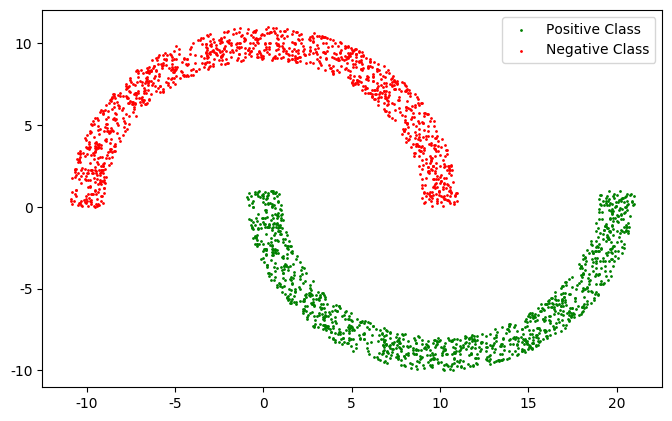

In [55]:
# 生成数据集
num_example = 2500
x =  dbmoon(N=num_example // 2)
y = np.concatenate([np.ones([num_example // 2]), -np.ones([num_example // 2])])

plt.figure(figsize=(8, 5), dpi=100)
plt.scatter(x[num_example // 2:, 0], x[num_example // 2:, 1], 1, color='green', label='Positive Class')
plt.legend(loc='best')
plt.scatter(x[: num_example // 2, 0], x[: num_example // 2, 1], 1, color='red', label='Negative Class')
plt.legend(loc='best')
plt.show()

In [56]:
# 将数据集打乱并分为训练集与测试集
train_x, test_x, train_y, test_y = train_test_split(x,y, test_size=600)

# 训练模型 5000 次
train_steps = 5000
# 摘要频率
summary_step =50
# 摘要，记录训练中的代价变化
summary = np.empty([train_steps // summary_step, 2])
# 学习率
lr = 0.2
# w是权值向量，b是偏置值
w = np.zeros([2], dtype=np.float32)
b = 0.

def rosenblatt(x):
    z = np.sum(w * x) + b
    if z >= 0:
        return 1
    else:
        return -1
    
def mse(label, pred):
    return np.average((np.array(label) - np.array(pred)) ** 2)


for i in range(0, train_steps):
    # 评估模型
    if i % summary_step == 0:
        test_out = []
        for j in range(test_y.shape[0]):
            test_out.append(rosenblatt(test_x[j]))
        loss = mse(test_y, test_out)
        idx = int(i / summary_step)
        summary[idx] = np.array([i, loss])
    
    # 取一个训练集中的样本
    one_x, one_y = train_x[i % train_y.shape[0]], train_y[i % train_y.shape[0]]
    # 得到模型输出结果
    out = rosenblatt(one_x )
    # 更新权值
    w = w + lr * (one_y - out) * (one_x)
    b = b + lr * (one_y - out) 

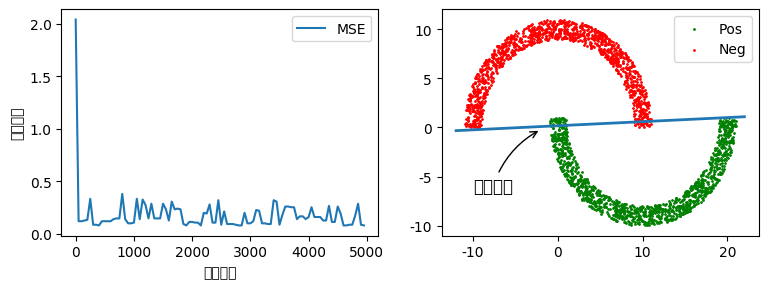

In [58]:
# 训练完成之后，我们将训练结果进行可视化。
plt.figure(figsize=(9, 3), dpi=100)

plt.subplot(1, 2, 1)
plt.plot(summary[:, 0], summary[:, 1], label='MSE')
plt.legend(loc='best')
plt.xlabel('迭代次数', fontproperties='SimHei')
plt.ylabel('均方误差', fontproperties='SimHei')

plt.subplot(1, 2, 2)
plt.scatter(x[num_example // 2:, 0], x[num_example // 2:, 1], 1, color='green', label='Pos')
plt.legend(loc='best')
plt.scatter(x[: num_example // 2, 0], x[: num_example // 2, 1], 1, color='red', label='Neg')
plt.legend(loc='best')
left_coord_y = (-b - (-12) * w[0]) / w[1]
right_coord_y = (-b - (22) * w[0]) / w[1]
plt.plot([-12, 22], [left_coord_y, right_coord_y], linewidth=2)

plt.annotate(
    '决策边界', xy=(-2, -0.2), xytext=(-10., -6.5), 
     arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-.2"), 
     fontproperties='SimHei', fontsize=12)

plt.show()

### 思考：根据上述训练结果以及决策边界的可视化结果，说明训练Rosenblatt感知器去解决线性不可分问题是否意味着模型完全失效？如果不是，思考在训练时如何确定训练终止条件。

 1.并不是完全失效
 2.终止条件条件可以根据迭代相邻次数的mse差值确定
 当相邻迭代次数的mse差值足够小时便可以终止，只与多少算小，可以自己测测

### 训练感知器模型时，使用到了学习率这个超参数，实际中，学习率是较难确定的超参数之一，为此提出了学习率衰减，请自行学习学习率衰减的原理与实现方法，并实现线性衰减学习率模型应用于Rosenblatt感知器模型的训练中。

tf.train.exponential_decay(learning_rate, global_step, decay_steps, decay_rate, staircase=False, name=None)

退化学习率,衰减学习率,将指数衰减应用于学习速率。
计算公式:

decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps)


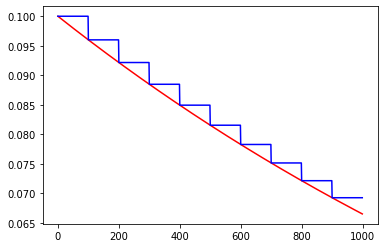

In [61]:
import tensorflow as tf
learning_rate = 0.1  # 初始学习速率时0.1
decay_rate = 0.96  # 衰减率
global_steps = 1000  # 总的迭代次数
decay_steps = 100  # 衰减次数

global_ = tf.Variable(tf.constant(0))
c = tf.train.exponential_decay(learning_rate, global_, decay_steps, decay_rate, staircase=True)
d = tf.train.exponential_decay(learning_rate, global_, decay_steps, decay_rate, staircase=False)

T_C = []
F_D = []

with tf.Session() as sess:
   for i in range(global_steps):
       T_c = sess.run(c, feed_dict={global_: i})
       T_C.append(T_c)
       F_d = sess.run(d, feed_dict={global_: i})
       F_D.append(F_d)

plt.figure(1)
plt.plot(range(global_steps), F_D, 'r-')# "-"表示折线图,r表示红色,b表示蓝色
plt.plot(range(global_steps), T_C, 'b-')
# 关于函数的值的计算0.96^(3/1000)=0.998
plt.show()

#### 线性余弦衰减
tf.train.linear_cosine_decay()　将线性余弦衰减应用于学习率． 
参数：

learning_rate：标初始学习率．
global_step：用于衰减计算的全局步数.
decay_steps：衰减步数。
num_periods：衰减余弦部分的周期数．
alpha：见计算．
beta：见计算．
name：操作的名称，默认为LinearCosineDecay。


#### 噪声线性余弦衰减的学习率计算公式为：
global_step=min(global_step,decay_steps)

linear_decay=(decay_steps-global_step)/decay_steps)

cosine_decay=0.5*(1+cos(pi*2*num_periods*global_step/decay_steps))

decayed=(alpha+linear_decay+eps_t)*cosine_decay+beta

decayed_learning_rate =learning_rate*decayed

W0620 22:39:02.920739 140044329453312 font_manager.py:1282] findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


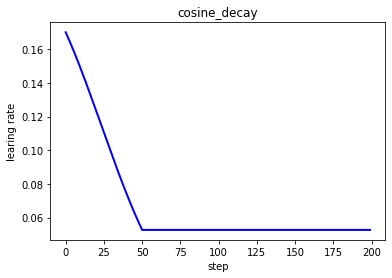

In [63]:
import matplotlib.pyplot as plt
import tensorflow as tf
y = []
z = []
w = []
N = 200
global_step = tf.Variable(0, name='global_step', trainable=False)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for global_step in range(N):

        # 线性余弦衰减
        learing_rate1 = tf.train.linear_cosine_decay(
            learning_rate=0.1, global_step=global_step, decay_steps=50,
            num_periods=0.2, alpha=0.5, beta=0.2)
        
        lr1 = sess.run([learing_rate1])
       
        z.append(lr1[0])
 

x = range(N)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(x, z, 'b-', linewidth=2)
plt.title('cosine_decay')
ax.set_xlabel('step')
ax.set_ylabel('learing rate')
plt.show()